In [2]:
# simulate a random walk in a 2D box
import numpy as np
m,n = 5,5
dstep = 0.2
nsteps = 100000 
x, y = m/2.0, n/2.0 
traj = np.zeros( (nsteps,2) )
for step in range(nsteps):
    traj[step,:] = x,y
    xnew, ynew = x+dstep*np.random.randn(), y+dstep*np.random.randn()
    # reject moves that cross the walls
    while (xnew < 0.0) or (xnew >= float(m)) or (ynew < 0.0) or (ynew >= float(n)):
        xnew, ynew = x+dstep*np.random.randn(), y+dstep*np.random.randn()
    x,y = xnew, ynew
    
# bin the trajectory into MSM states
def state(x,y, nrows=5, ncols=5):
    return ncols*int(y) + int(x)

itraj = np.zeros( nsteps )
for step in range(nsteps):
    itraj[step] = state(traj[step,0], traj[step,1])
    

/Users/vv/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


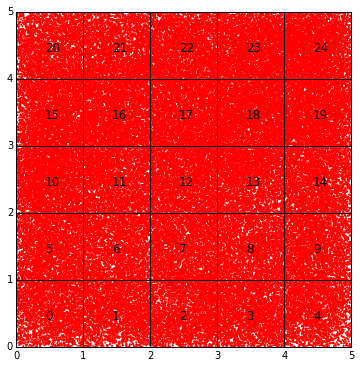

In [3]:
# Make a plot of our random-walk trajectory, and label the states
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(6,6))

plt.scatter(traj[:,0], traj[:,1], s=1, facecolors='none', edgecolors='r')
plt.xlim(0,m)
plt.ylim(0,n)
# plot dividing lines and labels
for i in range(1,m):
    plt.plot([i,i],[0,m],'k-')
    plt.plot([0,m],[i,i],'k-')
for x in range(m):
    for y in range(n):
        plt.text(x+0.44, y+0.4, str(state(x,y, nrows=m, ncols=n)), fontsize=12)
    
plt.show()

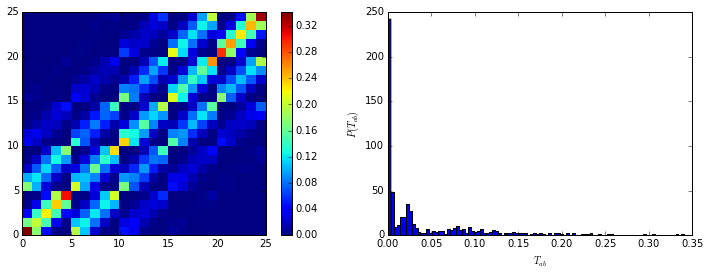

In [5]:
# Build an MSM
nstates = m*n

### Collect counts
C = np.ones( (nstates,nstates) )  # one pseudo-count per transition
lagtime = 25  # steps
for t in range(0,nsteps-lagtime):
    i, j = itraj[t], itraj[t+lagtime]
    C[i,j] += 1

    
# estimate T as a row-normalized C 
T = np.zeros( C.shape )
C_sym = (C + np.transpose(C))/2.0  # symmetrization is an easy way to achieve detailed balance in the limit of many counts
for i in range(C_sym.shape[0]):
    T[i,:] = C_sym[i,:]/C_sym[i,:].sum()
plt.figure(figsize=(12,4))        
plt.subplot(1,2,1)
plt.pcolor(T)
plt.colorbar()
plt.subplot(1,2,2)
plt.hist(T.flatten(), bins=100);
plt.xlabel('$T_{ab}$')
plt.ylabel('$P(T_{ab})$')

Requirements for Maximum Caliber approach of Dixit et al. JCTC 2015* 
* The equilibrium populations, $\pi_a$
* Jump indicators $N_{ab}$, to be constrained by the mean jump time $\langle N \rangle$ using Lagrange multiplier $\alpha$
* Dynamical quantities $r_{ab}$, to be constrained by the mean $\langle r \rangle$ using Lagrange multiplier $\gamma$

*Dixit, P. D., Jain, A., Stock, G., & Dill, K. A. (2015). Inferring Transition Rates of Networks from Populations in Continuous-Time Markov Processes. Journal of Chemical Theory and Computation, 11(11), 5464–5472. http://doi.org/10.1021/acs.jctc.5b00537)

pi_a.sum() 1.0 pi_a [ 0.03324056  0.03475149  0.03688867  0.03741551  0.03100398  0.03723658
  0.03583002  0.03859841  0.03676938  0.03628231  0.04637177  0.04078529
  0.04262922  0.03955765  0.03687873  0.04191849  0.04581511  0.04627237
  0.04852883  0.04701789  0.03429423  0.03883698  0.04160537  0.04596421
  0.04550696]
The mean jump rate N_mean = 0.791908548708
The mean distance traveled per unit time, r_mean = 1.1009347286


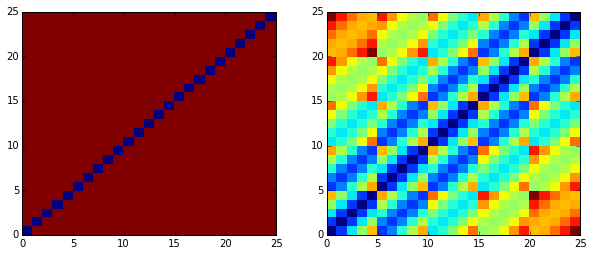

In [9]:
# Equilibrium populations should be uniform
if (0):
    pi_a = np.ones(T.shape[0])/float(nstates)
else:
    ### The stationary eigenvector of np.transpose(T) seems to work a bit better
    evals, evecs = np.linalg.eig(np.transpose(T))
    pi_a = evecs[:,np.argmax(evals)]
    pi_a = pi_a/pi_a.sum()
    print 'pi_a.sum()', pi_a.sum(), 'pi_a', pi_a


# Calculate matrix of jump indicators, N_ab
N_ab = np.ones(T.shape)
for i in range(T.shape[0]):
    N_ab[i,i] = 0.
    
# ... and the mean jump rate from the observed counts
N_mean = (N_ab*C_sym).sum()/C_sym.sum()
print 'The mean jump rate N_mean =', N_mean


# Calculate the matrix of dynamical observables r_ab
### in our case: the distance between state centers
r_ab = np.zeros(T.shape)
for x1 in range(m):
    for y1 in range(n):
        for x2 in range(m):
            for y2 in range(n):
                a, b = state(x1,y1, nrows=m, ncols=n), state(x2,y2, nrows=m, ncols=n)
                r_ab[a,b] = np.sqrt((x1-x2)**2 + (y1-y2)**2)

# ... and the mean r_ab from the observed counts
r_mean = (r_ab*C_sym).sum()/C_sym.sum()
print 'The mean distance traveled per unit time, r_mean =', r_mean


                
plt.figure(figsize=(10,4))        
plt.subplot(1,2,1)
plt.pcolor(N_ab)

plt.subplot(1,2,2)
plt.pcolor(r_ab)
plt.show()

Next, given a guess for the Lagrange multipliers $\alpha$ and $\gamma$, we solve a self-consistent set of equations to find $\beta_a$ and $\lambda_b$, the Lagrange multipliers corresponding to normalization constraints on outgoing transition probabilities from each state $a$, and incoming transition probabilities to states $b$, respectively.

We iterate:
* $\mathcal{D}[ \mathbf{W}\vec{\lambda} ] = \vec{\beta}$
* $\mathcal{D}[ \mathbf{W}^T\vec{\beta} ] = \vec{\lambda}$

where $\vec{\beta}$ and $\vec{\lambda}$ are vectors of Lagrange multipliers, $W_{ab} = e^{-\alpha N_{ab} - \gamma r_{ab}}$, and $\mathcal{D}$ is the non-linear operator $\mathcal{D}[\vec{x}]_a = \pi_a/x_a$.

Then, the maximum-caliber estimate of transition rates is $T_{ab}^{maxcal} = \frac{\beta_a}{\pi_a}\lambda_b \mathbf{W}_{ab}$, and we can choose Lagrange multipliers $\alpha$ and $\gamma$ to satisfy

$\sum_{a,b} \pi_a T_{ab}^{maxcal} N_{ab} = \langle N \rangle$

$\sum_{a,b} \pi_a T_{ab}^{maxcal} r_{ab} = \langle r \rangle$


#### BEST so far: alpha = -1.5 gamma = 1.4 ####
N_maxcal = 0.864130208561 N_mean =  0.791908548708
r_maxcal = 1.27496816583 r_mean =  1.1009347286
chi2 = 0.0355036054276
#### BEST so far: alpha = -1.5 gamma = 1.41 ####
N_maxcal = 0.862430211576 N_mean =  0.791908548708
r_maxcal = 1.26867241468 r_mean =  1.1009347286
chi2 = 0.0331092362649
#### BEST so far: alpha = -1.5 gamma = 1.42 ####
N_maxcal = 0.860718391389 N_mean =  0.791908548708
r_maxcal = 1.26241620467 r_mean =  1.1009347286
chi2 = 0.0308110615636
#### BEST so far: alpha = -1.5 gamma = 1.43 ####
N_maxcal = 0.858994752955 N_mean =  0.791908548708
r_maxcal = 1.25619899115 r_mean =  1.1009347286
chi2 = 0.028607550025
#### BEST so far: alpha = -1.5 gamma = 1.44 ####
N_maxcal = 0.857259301935 N_mean =  0.791908548708
r_maxcal = 1.25002023234 r_mean =  1.1009347286
chi2 = 0.026497208374
#### BEST so far: alpha = -1.5 gamma = 1.45 ####
N_maxcal = 0.855512044712 N_mean =  0.791908548708
r_maxcal = 1.24387938962 r_mean =  1.1009347286


/Users/vv/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


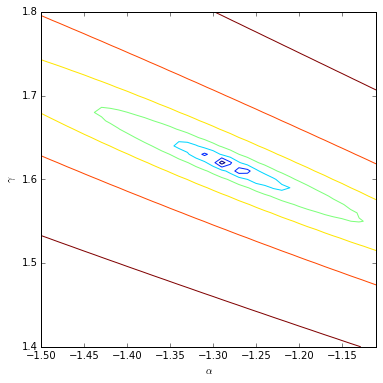

In [10]:
def D(x, pi):
    """$\mathcal{D}$ is the non-linear operator $\mathcal{D}[\vec{x}]_a = \pi_a/x_a$"""
    return pi * (1./x)

##############
### Let's do a scan for the best alpha and gamma

alpha_values = np.arange(-1.5, -1.1,0.01)
gamma_values = np.arange(1.4, 1.8,0.01)

# store the squared error (N_maxcal - N_mean)**2 + (r_maxcal - r_mean)**2 for each parameter set
chi2_results = np.zeros( (alpha_values.shape[0],gamma_values.shape[0]))

besti, bestj, best_chi2 = 0,0, 1.0e99

for i in range(len(alpha_values)):
    for j in range(len(gamma_values)):
        

        alpha = alpha_values[i]
        gamma = gamma_values[j]
        
        
        # calculate W_ab
        W = np.exp(-alpha*N_ab) * np.exp(-gamma*r_ab)

        tol = 1.0e-12
        max_delta = 1.0
        trial = 0
        beta_a = np.ones(nstates) # initial guess
        lambda_b = np.ones(nstates) # initial guess
        while max_delta > tol: 
    
            new_beta_a = D( np.dot(W,lambda_b), pi_a)
            new_lambda_b = D( np.dot(np.transpose(W), new_beta_a), pi_a)
    
            # measure the difference between old and new estimates
            diff_beta = new_beta_a - beta_a
            delta_beta = np.sqrt(np.dot(diff_beta,diff_beta))
    
            diff_lambda = new_lambda_b - lambda_b
            delta_lambda = np.sqrt(np.dot(diff_lambda,diff_lambda))
    
            max_delta = max(delta_beta,delta_lambda)
            #print 'trial', trial, 'beta_a =', beta_a[0:3], '... lambda_b =', lambda_b[0:3],'...', 'delta_beta', delta_beta, 'delta_lambda', delta_lambda

            beta_a = new_beta_a
            lambda_b = new_lambda_b
            trial += 1
    
        # print 'trial', trial, 'beta_a =', beta_a[0:3], '... lambda_b =', lambda_b[0:3],'...', 'delta_beta', delta_beta, 'delta_lambda', delta_lambda

        # Use the converged values of beta_a and lambda_b to get T^{maxcal}_ab 
        T_maxcal = np.zeros(T.shape)
        for a in range(nstates):
            for b in range(nstates):
                T_maxcal[a,b] = beta_a[a]/pi_a[a]*lambda_b[b]*W[a,b]
        # print 'T_maxcal', T_maxcal

        # print '#### For alpha =', alpha, 'gamma =', gamma, '####'
        N_maxcal = np.dot(pi_a, (T_maxcal*N_ab).sum(axis=1))
        # print 'N_maxcal =',N_maxcal, 'N_mean = ', N_mean
        r_maxcal = np.dot(pi_a, (T_maxcal*r_ab).sum(axis=1))
        #print 'r_maxcal =',r_maxcal, 'r_mean = ', r_mean

        chi2 = (N_maxcal - N_mean)**2 + (r_maxcal - r_mean)**2
        #print 'chi2 =', chi2
        
        if chi2 < best_chi2:
            best_chi2 = chi2
            besti, bestj = i,j
            best_alpha = alpha_values[besti]
            best_gamma = gamma_values[bestj]
            best_T_maxcal = T_maxcal
            print '#### BEST so far: alpha =', alpha, 'gamma =', gamma, '####'
            print 'N_maxcal =',N_maxcal, 'N_mean = ', N_mean
            print 'r_maxcal =',r_maxcal, 'r_mean = ', r_mean
            print 'chi2 =', chi2
        
        
        chi2_results[i,j] = chi2

plt.figure( figsize=(6,6))
X,Y = np.meshgrid(alpha_values, gamma_values)
plt.contour(X,Y, np.transpose(np.log(chi2_results)))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\gamma$')
plt.show()


And now, the moment of truth! Let's compare our transition matrix constructed form counts to the maxcal transition matrix 

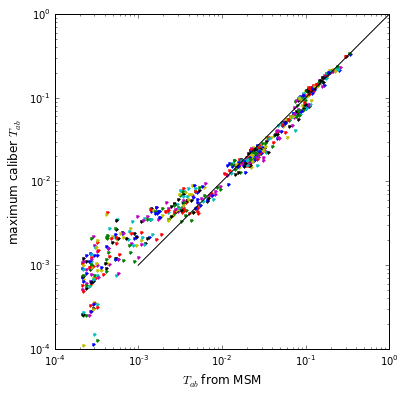

In [11]:
plt.figure(figsize=(6,6))
for a in range(T.shape[0]):
    for b in range(T.shape[1]):
        plt.plot(T[a,b], best_T_maxcal[a,b], '.' )
plt.xlabel('$T_{ab}$ from MSM', fontsize=12)
plt.ylabel('maximum caliber $T_{ab}$', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.plot([1,1e-3],[1,1e-3],'k-')
plt.show()